# Installation

In [1]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.4 MB/s eta 0:00:00


# Vérification avant de commencer

In [2]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


Visualisation des ressources et utilisation GPU

In [4]:
!nvidia-smi

Mon May 12 09:29:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vérification disponibilité GPU

In [5]:
import torch
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


# Préparation du dataset

In [6]:
!unzip -q /content/data.zip -d /content/custom_data_raw

## Organisation à avoir

```
custom_data/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/


## Réorganisation du dataset

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Répertoire d'origine pour les images et annotations
raw_data_path_images = "/content/custom_data_raw/images"  # Images sont dans ce dossier
raw_data_path_labels = "/content/custom_data_raw/obj_train_data"  # Annotations dans ce dossier

# Obtenir toutes les images (jpg/png) présentes dans le dossier "images"
images = [f for f in os.listdir(raw_data_path_images) if f.endswith(('.jpg', '.png'))]

# Split train/val (80% train, 20% val)
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Création des dossiers cible pour images et labels
base_path = "/content/custom_data"


os.makedirs(base_path + "/images/train", exist_ok=True)
os.makedirs(base_path + "/images/val", exist_ok=True)
os.makedirs(base_path + "/labels/train", exist_ok=True)
os.makedirs(base_path + "/labels/val", exist_ok=True)

def move_data(image_list, split):
    for img_name in image_list:
        # Déplacer l'image vers le bon dossier
        src_img = os.path.join(raw_data_path_images, img_name)
        dst_img = os.path.join(base_path, f"images/{split}", img_name)
        shutil.copy(src_img, dst_img)

        # Vérifier et déplacer l'annotation .txt correspondante
        txt_name = img_name.rsplit('.', 1)[0] + '.txt'
        txt_src = os.path.join(raw_data_path_labels, txt_name)
        txt_dst = os.path.join(base_path, f"labels/{split}", txt_name)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)
        else:
            print(f"Pas d'annotation pour {img_name}")

# Appliquer le déplacement aux deux splits : train et val
move_data(train_imgs, "train")
move_data(val_imgs, "val")


# Augmentation


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import os

# === PARAMÈTRES ===
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

# Tu appliques l'augmentation uniquement sur le dossier d'entraînement
augmented_path = "/content/custom_data_augmented/images/train"
augmented_label_path = "/content/custom_data_augmented/labels/train"
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(augmented_label_path, exist_ok=True)

original_train_images_path = "/content/custom_data/images/train"
original_train_labels_path = "/content/custom_data/labels/train"

# Copie les fichiers originaux
for img_file in tqdm(os.listdir(original_train_images_path), desc="Copie des images originales"):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(original_train_images_path, img_file)
    label_path = os.path.join(original_train_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Sauvegarde originale
    cv2.imwrite(os.path.join(augmented_path, img_file), img)
    shutil.copy(label_path, os.path.join(augmented_label_path, os.path.basename(label_path)))

    # Augmente 2 fois chaque image
    for i in range(2):
        augmented = augmentations(image=img)["image"]
        aug_img_name = img_file.replace('.', f'_aug{i}.')
        aug_lbl_name = img_file.replace('.jpg', f'_aug{i}.txt').replace('.png', f'_aug{i}.txt')

        cv2.imwrite(os.path.join(augmented_path, aug_img_name), augmented)
        shutil.copy(label_path, os.path.join(augmented_label_path, aug_lbl_name))

print("✅ Dataset augmenté.")


Copie des images originales: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]

✅ Dataset augmenté.


In [9]:
# Copie val original sans modification
original_val_images_path = "/content/custom_data/images/val"
original_val_labels_path = "/content/custom_data/labels/val"

val_img_out_dir = "/content/custom_data_augmented/images/val"
val_lbl_out_dir = "/content/custom_data_augmented/labels/val"

os.makedirs(val_img_out_dir, exist_ok=True)
os.makedirs(val_lbl_out_dir, exist_ok=True)

for img_file in os.listdir(original_val_images_path):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_src = os.path.join(original_val_images_path, img_file)
    lbl_src = os.path.join(original_val_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img_dst = os.path.join(val_img_out_dir, img_file)
    lbl_dst = os.path.join(val_lbl_out_dir, os.path.basename(lbl_src))

    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

print("✅ Validation copiée sans modification.")


✅ Validation copiée sans modification.


# Split des images du dataset

In [10]:
import os
import cv2
import shutil

# === PARAMÈTRES ===
# input_root = "/content/custom_data"
input_root = "/content/custom_data_augmented"

output_root = "/content/split_custom_data"

base_split_path = "/content/split_custom_data"

tile_size = 640
overlap = 0

splits = ["train", "val"]

def yolo_to_bbox(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, tile_w, tile_h):
    x_center = (x1 + x2) / 2 / tile_w
    y_center = (y1 + y2) / 2 / tile_h
    w = (x2 - x1) / tile_w
    h = (y2 - y1) / tile_h
    return x_center, y_center, w, h

# Boucle sur train et val
for split in splits:
    input_img_dir = os.path.join(input_root, f"images/{split}")
    input_lbl_dir = os.path.join(input_root, f"labels/{split}")
    output_img_dir = os.path.join(output_root, f"images/{split}")
    output_lbl_dir = os.path.join(output_root, f"labels/{split}")

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue

        basename = os.path.splitext(filename)[0]
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, f"{basename}.txt")

        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        annotations.append((cls, *yolo_to_bbox(xc, yc, w, h, img_w, img_h)))

        step = tile_size - overlap
        tile_id = 0

        for y in range(0, img_h, step):
            for x in range(0, img_w, step):
                tile = img[y:y + tile_size, x:x + tile_size]
                tile_h, tile_w = tile.shape[:2]

                if tile_h < tile_size or tile_w < tile_size:
                    continue

                tile_filename = f"{basename}_{tile_id}.jpg"
                label_filename = f"{basename}_{tile_id}.txt"
                tile_id += 1

                cv2.imwrite(os.path.join(output_img_dir, tile_filename), tile)

                new_annots = []
                for cls, x1, y1, x2, y2 in annotations:
                    if x1 >= x + tile_size or x2 <= x or y1 >= y + tile_size or y2 <= y:
                        continue

                    bx1 = max(0, x1 - x)
                    by1 = max(0, y1 - y)
                    bx2 = min(tile_size, x2 - x)
                    by2 = min(tile_size, y2 - y)

                    if bx2 - bx1 < 5 or by2 - by1 < 5:
                        continue

                    x_c, y_c, w, h = bbox_to_yolo(bx1, by1, bx2, by2, tile_size, tile_size)
                    new_annots.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

                with open(os.path.join(output_lbl_dir, label_filename), "w") as f:
                    f.write("\n".join(new_annots))

    print(f"✅ Split terminé pour '{split}' — {len(os.listdir(output_img_dir))} tuiles générées")


✅ Split terminé pour 'train' — 996 tuiles générées
✅ Split terminé pour 'val' — 88 tuiles générées


# Génération des YAML

Dynamique :

In [11]:
# Chemin vers le fichier obj.names exporté par CVAT (modifie si besoin)
obj_names_path = "/content/custom_data_raw/obj.names"

# Lire les noms de classes depuis obj.names
with open(obj_names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]

# Générer le contenu du fichier YAML avec les augmentations de couleur
yaml_content = f"""
path: {base_split_path}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente
"""


# Écriture du fichier data.yaml
with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

with open(f"{base_split_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print(" Fichier data.yaml généré automatiquement :")
print(yaml_content)


 Fichier data.yaml généré automatiquement :

path: /content/split_custom_data
train: images/train
val: images/val
nc: 2
names: ['olive', 'potential_olive']
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente



In [12]:
custom_train_cfg = """
# train_custom.yaml — Configuration d'entraînement pour YOLOv8

# Chemins
data: /content/split_custom_data/data.yaml
model: yolov8m.pt
# model: yolo11x.pt

# Entraînement
epochs: 300
batch: 16
imgsz: 320
# device: 0
patience: 10  # arrête si la val n'évolue plus pendant 10 epochs

# Hyperparamètres généraux
optimizer: SGD
lr0: 0.01
lrf: 0.01




# Augmentations géométriques
degrees: 00.0
translate: 0.0
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5

# Augmentations de couleur (adapté olives/feuillage)
hsv_h: 0.02
hsv_s: 0.6
hsv_v: 0.5

# Avancées
mosaic: 0.3
mixup: 0.1
copy_paste: 0.6

# auto_augment: randaugment
auto_augment: albumentations

"""

# Écriture du fichier YAML
with open("/content/custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")

with open(f"/content/split_custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")


✅ Fichier train_custom.yaml généré.
✅ Fichier train_custom.yaml généré.


## Vérification des labels et autres

In [13]:
import os
from collections import Counter

# Dictionnaire des classes : adapte-le si jamais tu changes l'ordre ou les noms
class_names = {
    '0': 'olive',
    '1': 'potential_olive'
}

def analyze_labels(labels_dir):
    label_counts = Counter()

    for split in ['train', 'val']:
        dir_path = os.path.join(labels_dir, split)
        for file in os.listdir(dir_path):
            if file.endswith('.txt'):
                with open(os.path.join(dir_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            label_counts[class_id] += 1

    print(" Résumé des classes dans les annotations :\n")
    for class_id, count in label_counts.items():
        class_name = class_names.get(class_id, " Inconnu")
        print(f"Classe {class_id} ({class_name}) → {count} objets")

    # Alerte pour les classes non attendues
    for cid in label_counts:
        if cid not in class_names:
            print(f"\n ID inattendu détecté : {cid}")

# Appel de la fonction
analyze_labels(f"{base_split_path}/labels")


 Résumé des classes dans les annotations :

Classe 0 (olive) → 5950 objets
Classe 1 (potential_olive) → 95 objets


# Train COCO

- Changer le nombre d'epochs : Avec seulement 6 images et un grand déséquilibre, 10 epochs peuvent ne pas être suffisants. Essaie d'augmenter le nombre d'epochs (par exemple, à 50 ou 100) pour donner au modèle plus de temps pour apprendre.

- Réduire le imgsz : La taille des images peut avoir un impact sur l'entraînement. Si les images sont petites (moins de détails), une taille de 320x320 ou 416x416 pourrait mieux fonctionner qu'une taille de 640x640, qui peut être plus difficile à traiter.

In [14]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")  # ou un autre modèle préentraîné

# Geler les premières couches
for param in model.model.model[0].parameters():
    param.requires_grad = False

model.train(
    data=f"{base_split_path}/data.yaml",
    epochs=50,
    device=0,
    batch=16,
    imgsz=640,
    patience=20,
    optimizer='SGD',
    lr0=0.001,
    lrf=0.01,
    degrees=0.0,
    translate=0.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    hsv_h=0.02,
    hsv_s=0.6,
    hsv_v=0.5,
    mosaic=0.5,
    mixup=0.1,
    copy_paste=0.7,
    auto_augment='albumentations'
)


100%|██████████| 49.7M/49.7M [00:00<00:00, 166MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=albumentations, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.7, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.6, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pret

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           


  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384, 576, 3, 2]              
  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576,

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1815.0±1208.9 MB/s, size: 186.7 KB)


train: Scanning /content/split_custom_data/labels/train... 996 images, 380 backgrounds, 0 corrupt: 100%|██████████| 996/996 [00:00<00:00, 2533.57it/s]


train: New cache created: /content/split_custom_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1318.1±964.0 MB/s, size: 227.1 KB)


val: Scanning /content/split_custom_data/labels/val... 88 images, 35 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 2289.08it/s]

val: New cache created: /content/split_custom_data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.22G      2.301      4.123      1.788         14        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         88        629      0.809      0.195      0.224       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.41G      2.023      2.647      1.607         31        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         88        629      0.848      0.223      0.269       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.37G      2.004       2.48      1.578         38        640: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         88        629       0.86      0.282       0.33      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.32G      1.912      2.275      1.484         11        640: 100%|██████████| 63/63 [00:33<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         88        629       0.89      0.282      0.347      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.35G      1.842      2.176      1.429         34        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         88        629       0.89      0.317      0.359      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       6.4G       1.81      2.128      1.393         11        640: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         88        629        0.9      0.313      0.388      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.36G      1.789       2.26      1.385          4        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         88        629      0.876      0.331      0.367      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.32G      1.744      2.092      1.361         15        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         88        629      0.898       0.34      0.393      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.42G      1.766      2.056      1.376         42        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         88        629      0.884      0.333      0.374      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.32G      1.662      1.948      1.303         17        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         88        629      0.892      0.339      0.386      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       6.3G      1.677      1.937      1.306         46        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         88        629      0.892       0.35      0.381      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.31G      1.681      1.932      1.307         24        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         88        629      0.908      0.328      0.391      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.39G      1.647      1.886      1.304         20        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         88        629       0.91      0.342      0.396      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.39G      1.707      1.971      1.324         21        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         88        629      0.895      0.356      0.393      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       6.4G      1.583      1.773      1.272         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         88        629      0.892       0.36      0.402       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.22G      1.625      1.879      1.291         13        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         88        629      0.392      0.355      0.388      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       7.4G      1.537      1.691      1.217         50        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         88        629      0.921      0.349      0.405      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.34G      1.588      1.785      1.268         33        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         88        629       0.41      0.342      0.403      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       6.4G      1.623      1.866      1.294         25        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         88        629      0.891      0.358      0.394      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.21G      1.563      1.768      1.268         26        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         88        629      0.401      0.365      0.404      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.39G      1.566      1.758      1.258         41        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         88        629      0.904      0.353      0.405      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.32G      1.576      1.803      1.264          6        640: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         88        629      0.919      0.353      0.406      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.41G       1.57      1.781      1.251         94        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         88        629      0.896      0.363      0.404      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.24G      1.578      1.764      1.259         51        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         88        629      0.393       0.37      0.398      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.38G      1.541      1.767      1.247         29        640: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         88        629      0.395      0.357      0.394      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.29G      1.626      1.816      1.274         38        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         88        629      0.405      0.361      0.396      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.3G      1.566      1.791      1.259         36        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         88        629      0.388      0.356      0.388      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.31G      1.589      1.878      1.263          8        640: 100%|██████████| 63/63 [00:33<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         88        629      0.888      0.364      0.395       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       6.4G      1.487      1.651      1.201         14        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         88        629      0.386      0.359       0.38      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.32G      1.461      1.604      1.199         23        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         88        629       0.39      0.362      0.386      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.4G      1.507      1.751      1.231         22        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         88        629      0.392      0.364      0.395      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.29G        1.5      1.651      1.222          9        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         88        629      0.393      0.357      0.386      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.34G      1.552      1.757      1.233          4        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         88        629      0.401      0.355      0.398      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.31G      1.488      1.664      1.213         38        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         88        629      0.399       0.36      0.396      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.39G       1.45      1.581      1.185         39        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         88        629      0.398       0.35      0.383      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.21G        1.5      1.647      1.215         40        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         88        629      0.394      0.363      0.394      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.39G       1.39      1.517      1.162         20        640: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         88        629        0.4      0.361      0.408      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.34G      1.493      1.651      1.205         27        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         88        629      0.396      0.358      0.393       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.38G      1.493      1.696      1.211         60        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         88        629      0.402      0.362      0.399       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.29G      1.416      1.569      1.174         10        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         88        629        0.4      0.374      0.407      0.259


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.29G      1.404      1.595      1.191         36        640: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         88        629      0.398      0.369      0.406      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.31G      1.403      1.602      1.199         26        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         88        629      0.398      0.365      0.393      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.34G      1.388      1.538      1.191         12        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         88        629      0.404       0.36      0.397      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.27G      1.429      1.624      1.218         15        640: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         88        629      0.402       0.36      0.396      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.39G      1.391      1.559      1.186         26        640: 100%|██████████| 63/63 [00:33<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         88        629      0.393      0.357      0.393      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.3G      1.376      1.532      1.182         17        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         88        629      0.402      0.354      0.389      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.34G      1.444      1.639      1.236         20        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88        629      0.399      0.354      0.387      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.3G       1.36      1.507      1.173         11        640: 100%|██████████| 63/63 [00:32<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         88        629      0.403      0.355       0.39      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.31G        1.4      1.579      1.208          7        640: 100%|██████████| 63/63 [00:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         88        629        0.4      0.358      0.392      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.38G      1.381      1.514      1.184         15        640: 100%|██████████| 63/63 [00:33<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         88        629      0.403      0.361      0.393      0.249



50 epochs completed in 0.494 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


                   all         88        629        0.4      0.373      0.407      0.259
                 olive         52        611      0.799      0.746      0.803      0.513
       potential_olive         10         18          0          0     0.0109    0.00521
Speed: 0.2ms preprocess, 11.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ccfef613110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# Train Github


In [ ]:
!wget https://github.com/g-sferr/Olive-SmartScan_AI/blob/main/final_models/checkpoints/3_YOLOv8%20Medium/Best_YOLOv8_M.zip


Important : ton data.yaml doit avoir les mêmes noms de classes que ceux du modèle préentraîné (probablement ["olive"]). Vérifie dans son fichier data.yaml

In [ ]:
from ultralytics import YOLO

# Charger le modèle préentraîné sur des olives (et non COCO)
model = YOLO("/content/best_olive.pt")

# (Facultatif) Geler les premières couches si tu veux fine-tuner légèrement
for param in model.model.model[0].parameters():
    param.requires_grad = False

# Entraînement (tu adaptes les hyperparams comme tu veux)
model.train(
    data=f"{base_split_path}/data.yaml",
    epochs=100,
    batch=16,
    imgsz=320,
    patience=10,
    optimizer='SGD',
    lr0=0.001,  # plus petit lr car on fine-tune
    lrf=0.01,
    mosaic=0.3,
    copy_paste=0.6,
    auto_augment='albumentations'
)


In [ ]:
#yolo task=detect mode=train model=yolo11n.pt data={base_path}/data.yaml hyp={base_path}/hyp.yaml epochs=100 imgsz=640 device=0

# Résultats

In [16]:
import glob
from IPython.display import Image, display

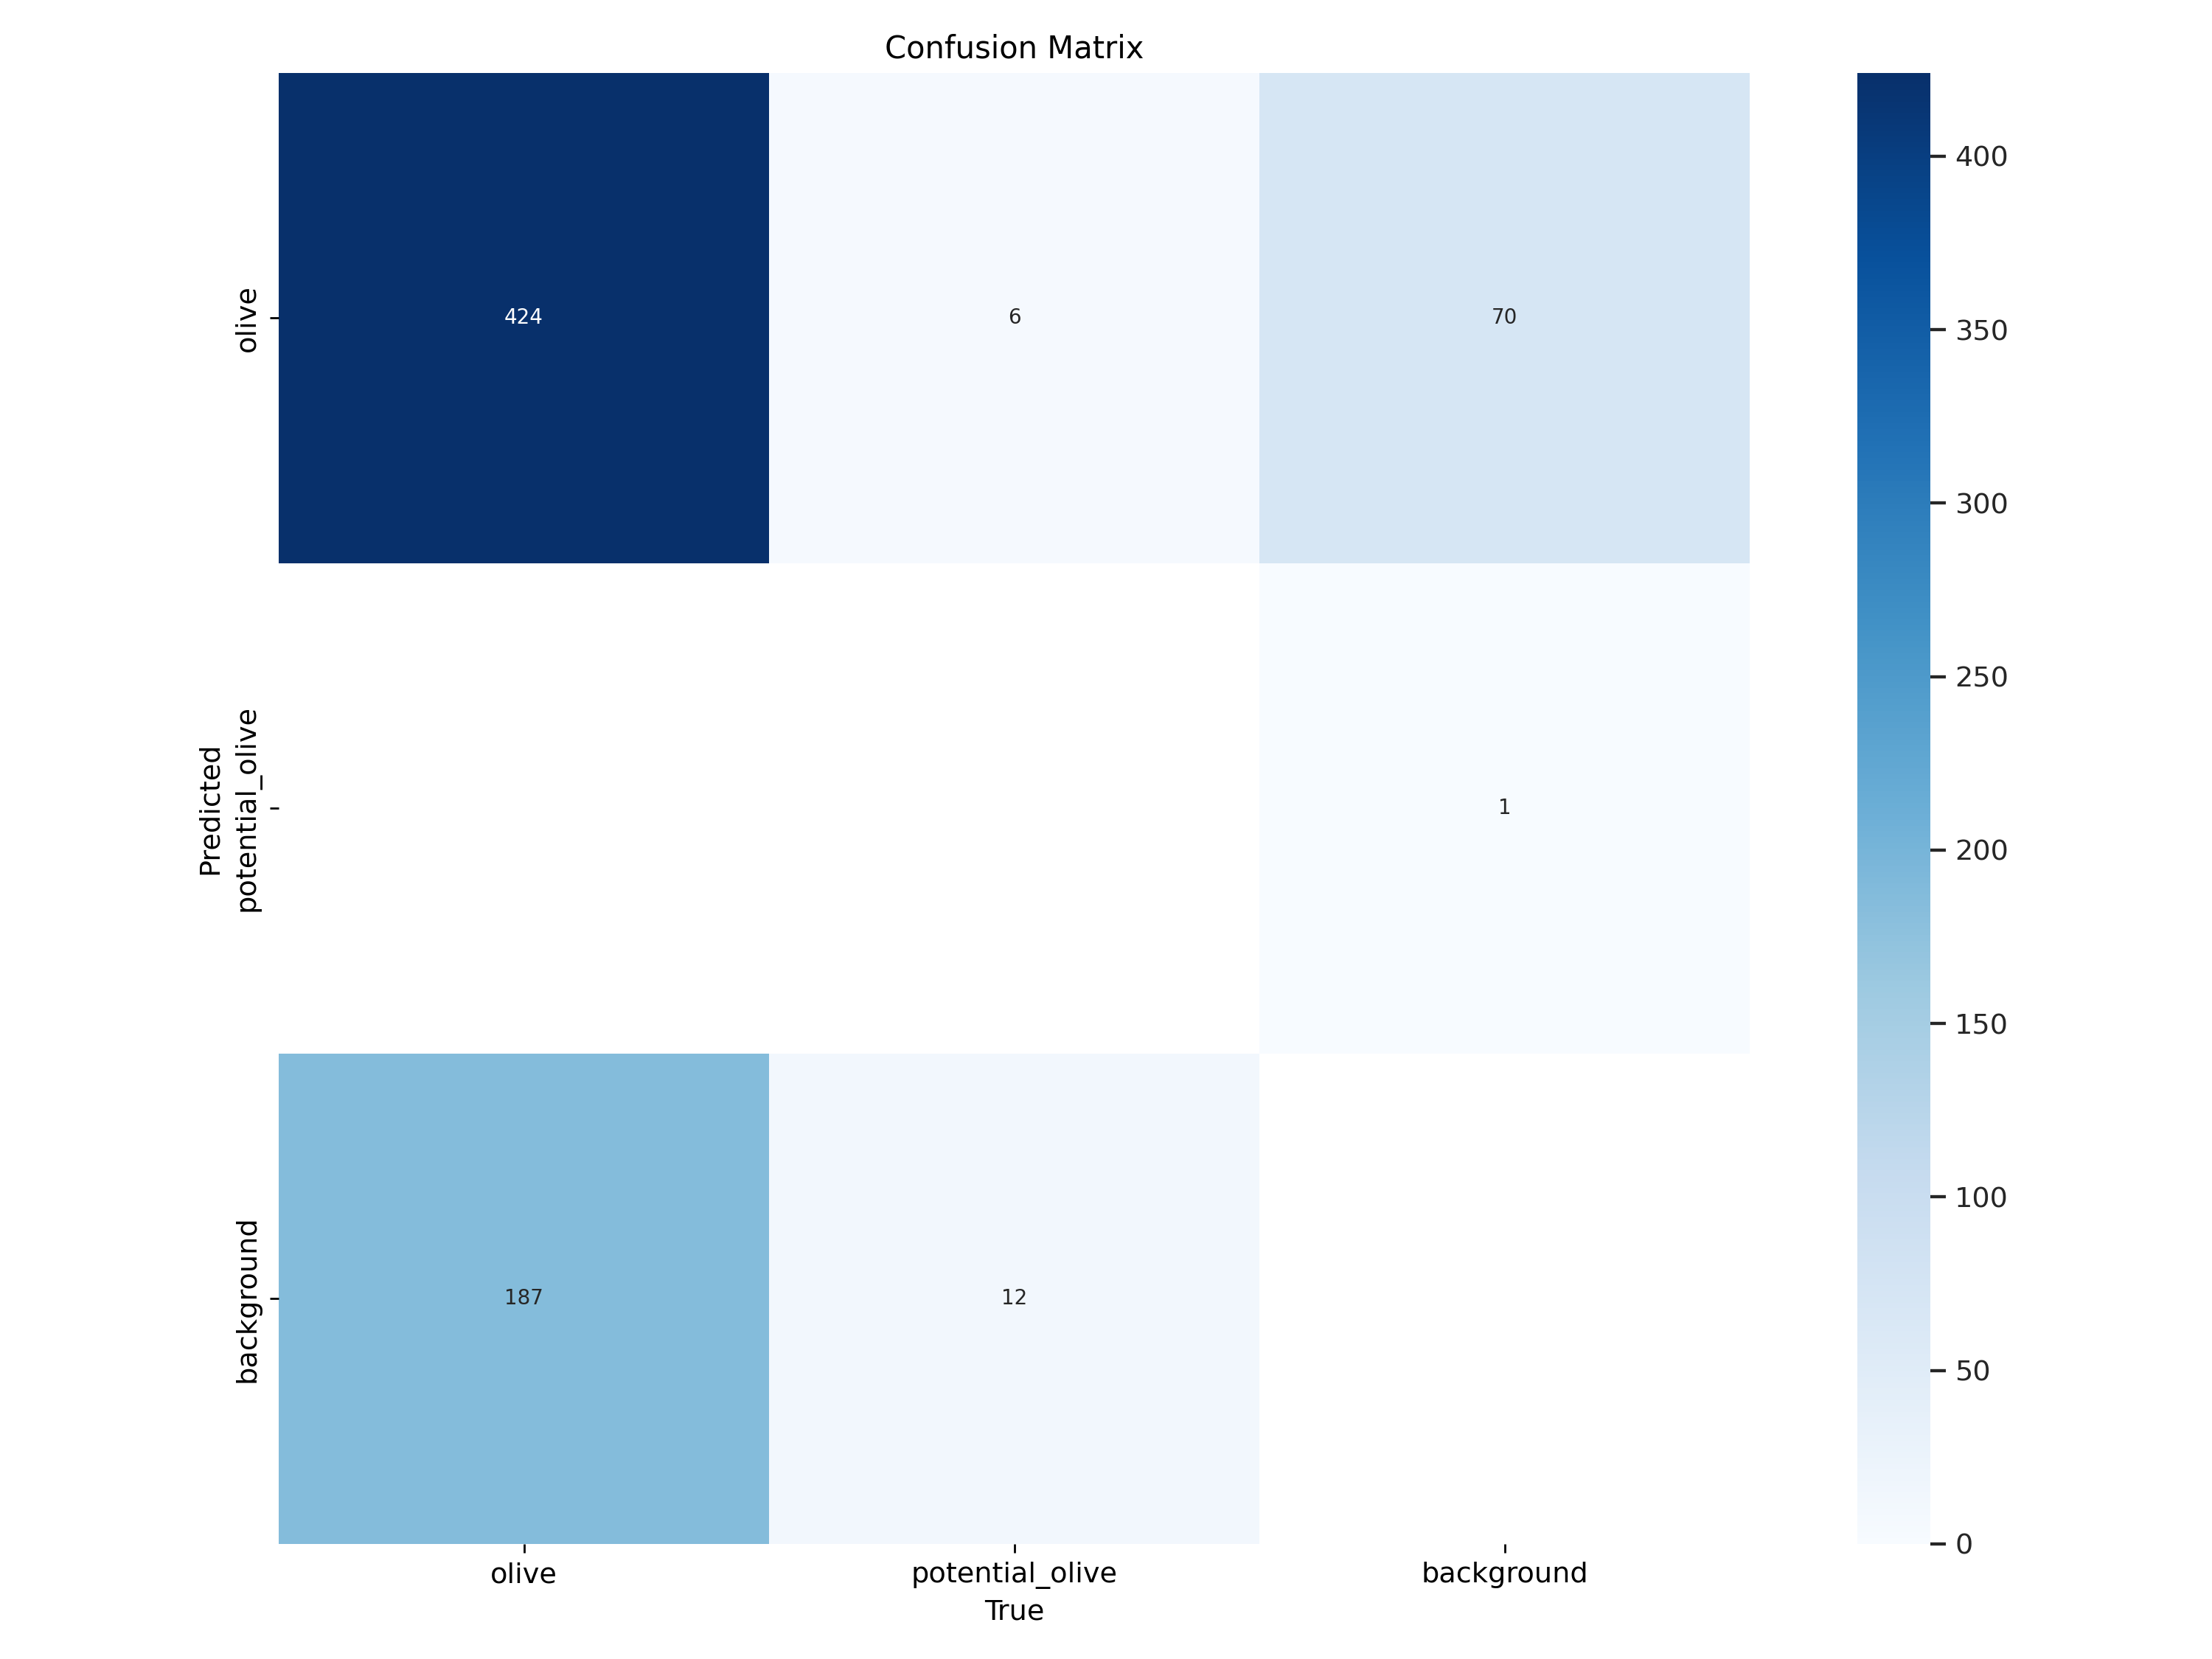

In [17]:
Image(filename='runs/detect/train/confusion_matrix.png', width=600)

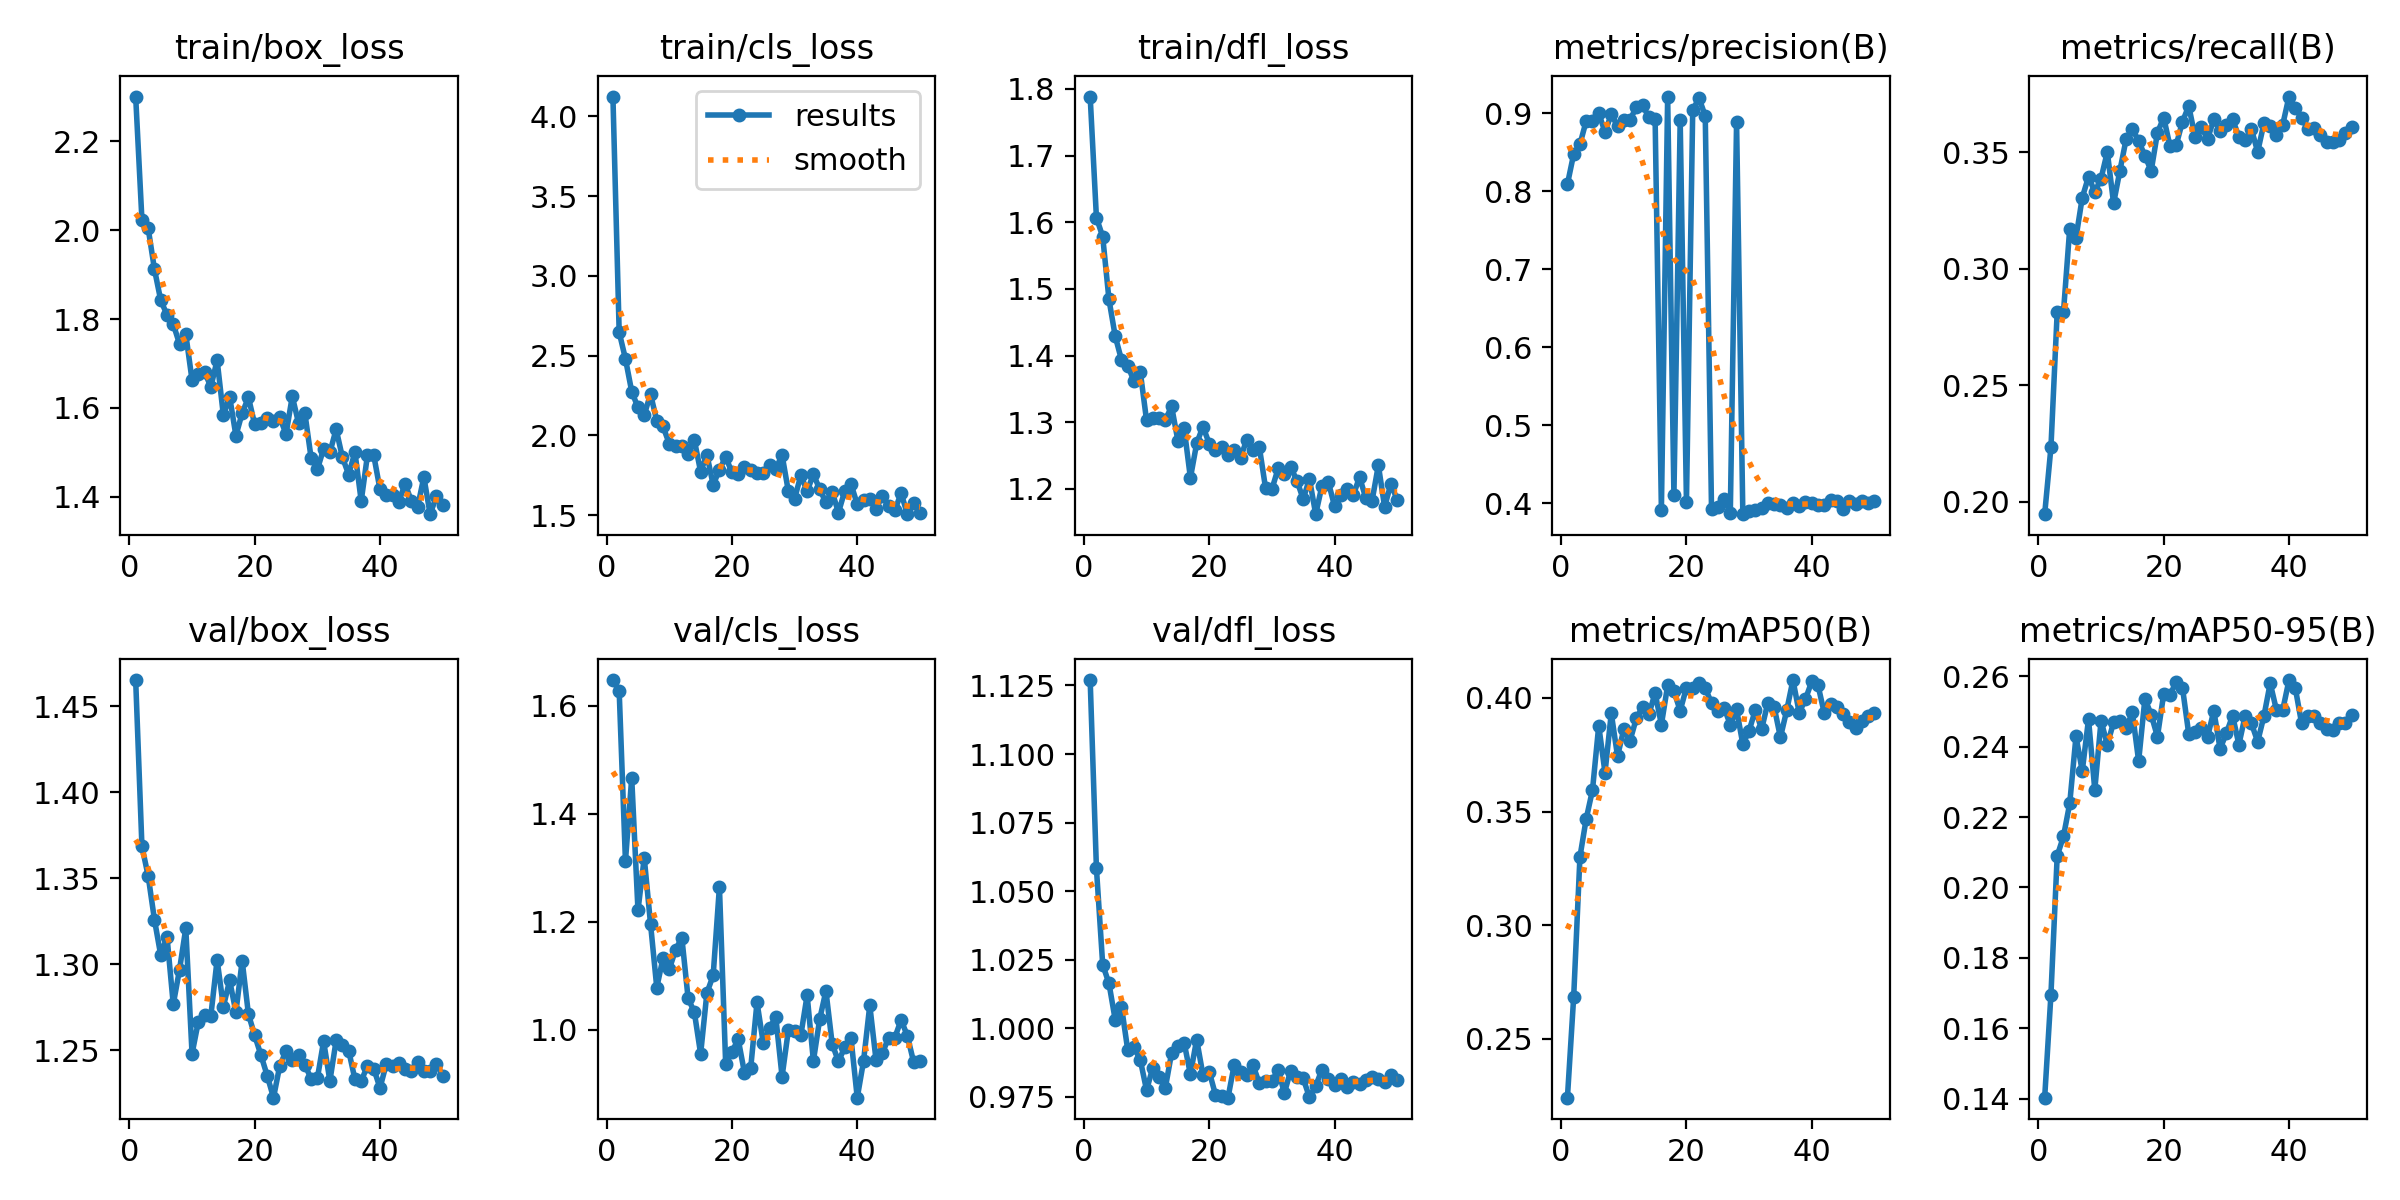

In [18]:
Image(filename='runs/detect/train/results.png', width=600)

# Validation

In [19]:
from ultralytics import YOLO

# Charger le modèle entraîné
model = YOLO("runs/detect/train/weights/best.pt")

# Évaluer sur le dataset de validation
metrics = model.val(data="/content/split_custom_data/data.yaml", split="val", verbose=False)

# Accès aux métriques par classe
names = model.names  # dict {class_id: name}
precision_per_class = metrics.box.p  # Précision par classe
recall_per_class = metrics.box.r  # Rappel par classe
map50_per_class = metrics.box.ap50  # mAP à IoU de 0.5 par classe
map_per_class = metrics.box.ap  # mAP à IoU de 0.5-0.95 par classe

# Exemple : récupérer les métriques de la classe "olive"
class_name = "olive"
class_id = list(names.values()).index(class_name)

print(f"Métriques pour la classe '{class_name}':")
print(f" - Précision : {precision_per_class[class_id]:.3f}")
print(f" - Rappel    : {recall_per_class[class_id]:.3f}")
print(f" - mAP@50    : {map50_per_class[class_id]:.3f}")
print(f" - mAP@50-95 : {map_per_class[class_id]:.3f}")


Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2502.5±668.9 MB/s, size: 199.3 KB)


val: Scanning /content/split_custom_data/labels/val.cache... 88 images, 35 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


                   all         88        629      0.401      0.374      0.408       0.26
Speed: 4.5ms preprocess, 24.3ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/val
Métriques pour la classe 'olive':
 - Précision : 0.802
 - Rappel    : 0.748
 - mAP@50    : 0.804
 - mAP@50-95 : 0.515


En modifiant conf

In [21]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import os
from ultralytics.utils.metrics import bbox_iou

# 🔧 Paramètres
model_path = "runs/detect/train/weights/best.pt"
data_path = "/content/split_custom_data/data.yaml"
val_images_dir = "/content/split_custom_data/images/val"
conf_threshold = 0.05  # 🔁 MODIFIE ici le seuil de confiance
target_class = "olive"
iou_threshold = 0.5  # pour comptage TP/FN

# 📦 Charger modèle + noms des classes
model = YOLO(model_path)
names = model.names
target_id = list(names.values()).index(target_class)

# 📂 Liste des fichiers image de validation
image_paths = list(Path(val_images_dir).rglob("*.jpg")) + list(Path(val_images_dir).rglob("*.png"))

# 🔢 Compteurs
TP, FP, FN = 0, 0, 0

# 🔍 Parcourir les images
import torch

# 🔍 Parcourir les images
for img_path in image_paths:
    results = model.predict(source=str(img_path), conf=conf_threshold, iou=iou_threshold, verbose=False)[0]

    # Prédictions pour la classe cible
    preds = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == target_id]
    pred_boxes = [b[:4] for b in preds]  # x1, y1, x2, y2

    # Ground truth : via les annotations val
    label_path = str(img_path).replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                if int(cls) == target_id:
                    # YOLO format -> (x1, y1, x2, y2)
                    img = cv2.imread(str(img_path))
                    H, W = img.shape[:2]
                    cx, cy, bw, bh = x * W, y * H, w * W, h * H
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    gt_boxes.append([x1, y1, x2, y2])

    # 🧠 Matching GT ↔ prédictions
    matched_gt = set()
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            # Convertir en tensor avant de calculer l'IoU
            pred_box_tensor = torch.tensor(pred_box).unsqueeze(0)  # Convertir en tensor
            gt_box_tensor = torch.tensor(gt_box).unsqueeze(0)  # Convertir en tensor
            iou = bbox_iou(pred_box_tensor, gt_box_tensor)[0]  # Calcul de l'IoU
            if iou > iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1
    FN += len(gt_boxes) - len(matched_gt)

# 📊 Calcul des métriques
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\n🔎 Résultats pour la classe '{target_class}' (seuil conf = {conf_threshold}):")
print(f" - Vrais positifs (TP) : {TP}")
print(f" - Faux positifs (FP)  : {FP}")
print(f" - Faux négatifs (FN)  : {FN}")
print(f" - Précision           : {precision:.3f}")
print(f" - Rappel              : {recall:.3f}")




🔎 Résultats pour la classe 'olive' (seuil conf = 0.05):
 - Vrais positifs (TP) : 545
 - Faux positifs (FP)  : 235
 - Faux négatifs (FN)  : 66
 - Précision           : 0.699
 - Rappel              : 0.892


# Predict

- Vérifie les prédictions avec conf=0.5 ou plus bas : Parfois, si le modèle est trop conservateur, il ne détecte rien parce qu'il exige une très forte confiance. Essaie de réduire le seuil de confiance lors de la prédiction.

In [ ]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source={base_split_path}/images/val conf=0.5 save=True device=0

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs

image 1/7 /content/custom_data/images/val/20221108_112521.jpg: 640x288 1 olive, 68.5ms
image 2/7 /content/custom_data/images/val/B18.jpg: 640x288 5 olives, 40.0ms
image 3/7 /content/custom_data/images/val/B2.1.jpg: 640x288 5 olives, 39.9ms
image 4/7 /content/custom_data/images/val/B2.13.jpg: 640x288 16 olives, 40.0ms
image 5/7 /content/custom_data/images/val/IMG_20221123_154057.jpg: 640x480 71 olives, 56.6ms
image 6/7 /content/custom_data/images/val/IMG_20231104_105335.jpg: 480x640 20 olives, 56.5ms
image 7/7 /content/custom_data/images/val/IMG_20231108_122534.jpg: 640x480 50 olives, 69.9ms
Speed: 2.4ms preprocess, 53.0ms inference, 49.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


# Télécharger le modèle

In [22]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch0.jpg (deflated 3%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/val_batch0_pred.jpg (deflated 4%)
  adding: train/train_batch2520.jpg (deflated 3%)
  adding: train/confusion_matrix.png (deflated 34%)
  adding: train/R_curve.png (deflated 13%)
  adding: train/results.png (deflated 7%)
  adding: train/val_batch0_labels.jpg (deflated 4%)
  adding: train/results.csv (deflated 61%)
  adding: train/train_batch1.jpg (deflated 2%)
  adding: train/val_batch2_pred.jpg (deflated 5%)
  adding: train/labels.jpg (deflated 26%)
  adding: train/args.yaml (deflated 51%)
  adding: train/train_batch2.jpg (deflated 1%)
  adding: train/PR_curve.png (deflated 16%)
  adding: train/labels_correlogram.jpg (deflated 38%)
  adding: train/F1_curve.png (deflated 14%)
  adding: train/confusion_matrix_normali